In [7]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [8]:
IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../../data/processed/04_kaggle_dataset"

# 조금 더 보수적으로
datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [11]:
# 모델 정의
base_model=MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=False

model=Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

MODEL_PATH="../../src/models/24_mobilenetv2_tuned/best_model.keras"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
mcp=ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
es=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reducelr=ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

In [12]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[mcp, es, reducelr], verbose=1)

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7648
Epoch 1: val_loss improved from inf to 0.31855, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 49s 189ms/step - loss: 0.4868 - accuracy: 0.7648 - val_loss: 0.3185 - val_accuracy: 0.8779 - lr: 1.0000e-04
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8866
Epoch 2: val_loss improved from 0.31855 to 0.24783, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 47s 187ms/step - loss: 0.2869 - accuracy: 0.8866 - val_loss: 0.2478 - val_accuracy: 0.9053 - lr: 1.0000e-04
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.9044
Epoch 3: val_loss improved from 0.24783 to 0.22564, saving model to ../../src/models/24_mobilenetv2_tuned/best_model.keras
251/251 [==============================] - 47

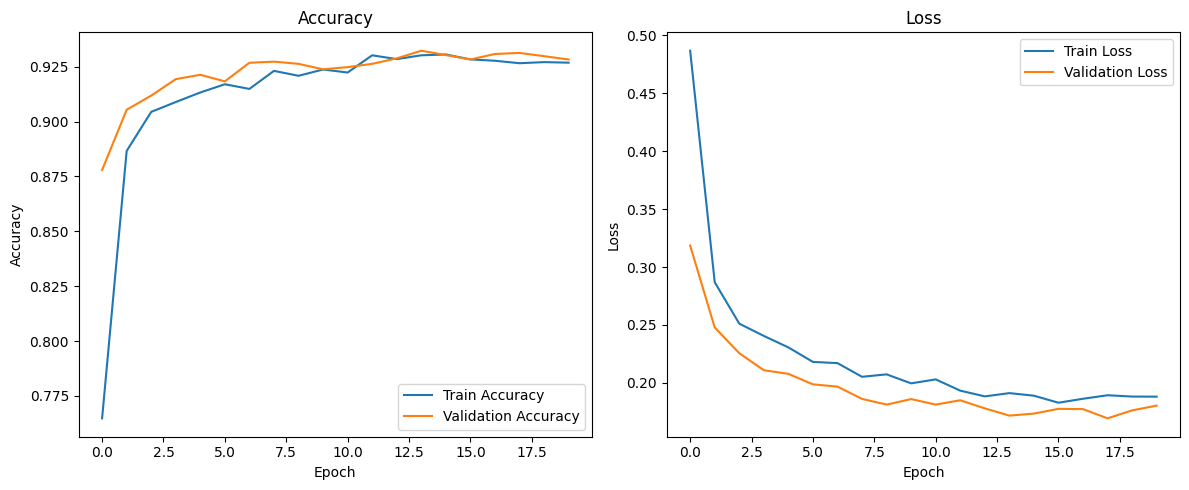

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/24_mobilenetv2_training_plot.png")
plt.show()

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.92      0.94      0.93      1000
      Opened       0.94      0.92      0.93      1007

    accuracy                           0.93      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.93      0.93      0.93      2007



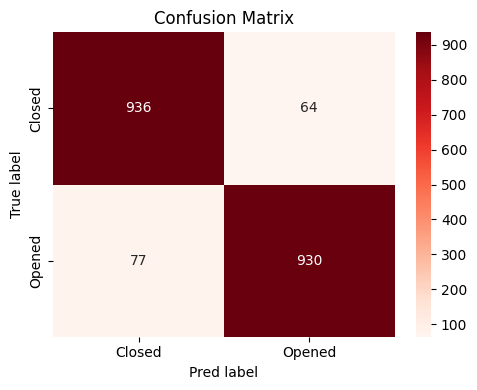

In [14]:
steps=val_generator.samples // val_generator.batch_size + 1
y_true=val_generator.classes
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
print("=== Classification Report ===")
print(report)

with open("../../results/reports/24_mobilenetv2_classification_report.txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
plt.title("Confusion Matrix")
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("../../results/images/24_mobilenetv2_confusion_matrix.png")
plt.show()

In [15]:
model.save("../../src/models/24_mobilenetv2_tuned/model.keras")